In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glikonal_mrap as mrap
import matplotlib



##  MRAP
We implement a variant of the fast marching method (See Sethian 1996) to solve the minimal return altitude problem (MRAP). Our implementation uses a square grid with spacing h. This implementation does not take the wind into account.

## Point source test with constant wind and no terrain
In this case the analytic solution is known and we can compare to it.

In [2]:
H=101 #height of the square grid
W=101 #width of the square grid
h=1 #spacing of the square grid
elevation=0*np.ones([H,W]) #elevation profile
g=1 #glide ratio
#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=0

In [3]:
#use the solver to obtain the approximate solution
radius=3 #radius of the neighbourhood of the initial point 
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g) #solve the HJB equation in a neighbourhood of specified radius of the initial point, in order to have a more precise solution near the initial point.
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W) #solve the HJB equation on the whole grid
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))

In [4]:
#finding the true solution
radius=np.sqrt((H*h)**2+(h*W)**2)
true_grid=np.zeros([H,W])
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]


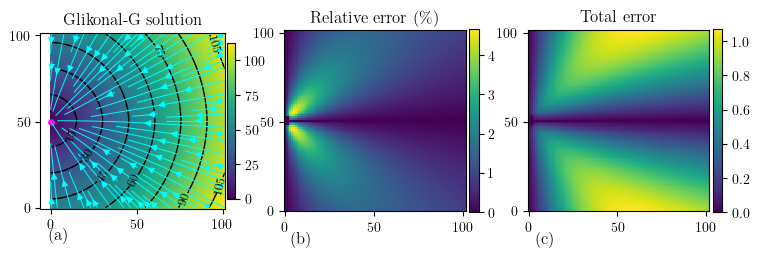

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})
X,Y=np.meshgrid(np.linspace(0,h*W,W),np.linspace(0,h*H,H))

tot_error=grid-true_grid
rel_error=tot_error/(true_grid+1e-10)
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))
fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*h,init_pos[0]*h,color='magenta',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.04, pad=0.01)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,-grid_chars[:,:,1],-grid_chars[:,:,0],density=0.9,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)


plt.savefig('./pics/glikonal_mrap_test_flat.pdf',dpi=600,bbox_inches='tight')

## Test with barrier with two slits
 In this example we test the behavior of the algorithm in the case of a barrier (a mountain range) with two slits (mountain passes)

In [6]:
H=101
W=101

h=1 #spacing of the square grid
elevation=np.zeros([H,W])
elevation[:,W//2]=100*np.ones(H)
g=1

saddle_1=80
saddle_2=10
elevation[int(saddle_1/h),:]=1
elevation[int(saddle_2/h),:]=1

#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=0

In [7]:
#use the solver to obtain the approximate solution
radius=3
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))

In [8]:
#computing the true solution
radius=np.sqrt((H*h)**2+(h*W)**2)
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
init_pos_saddle1=(int(saddle_1/h),W//2)
alt_saddle1=init_values[init_nodes.index(init_pos_saddle1)]

init_pos_saddle2=(int(saddle_2/h),W//2)
alt_saddle2=init_values[init_nodes.index(init_pos_saddle2)]


init_nodes1,init_values1=mrap.point_source_HJB_uniform_solver_MRAP(init_pos_saddle1,alt_saddle1,radius,H,W,h,g)
init_nodes2,init_values2=mrap.point_source_HJB_uniform_solver_MRAP(init_pos_saddle2,alt_saddle2,radius,H,W,h,g)

true_grid=np.inf*np.ones([H,W])

for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
for i,pos in enumerate(init_nodes1):
    if(pos[1]>W//2):
        true_grid[pos]=min(init_values2[init_nodes2.index(pos)],init_values1[init_nodes1.index(pos)])

true_grid=np.maximum(true_grid,np.zeros_like(true_grid))
true_grid[:,W//2]=elevation[:,W//2]
true_grid[init_pos_saddle1]=alt_saddle1
true_grid[init_pos_saddle2]=alt_saddle2


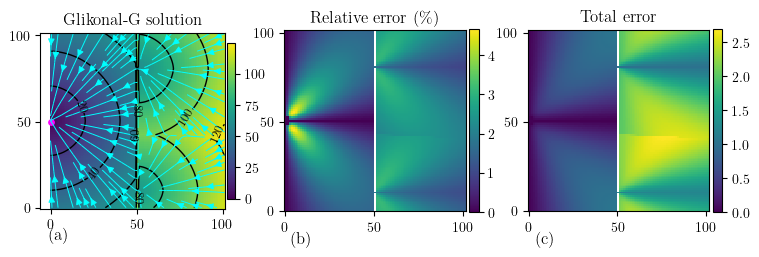

In [9]:
X,Y=np.meshgrid(np.linspace(0,h*W,W),np.linspace(0,h*H,H))

tot_error=grid-true_grid

tot_error[:int(saddle_2/h),W//2]=np.inf*np.ones(int(saddle_2/h))
tot_error[int(saddle_1/h)+1:,W//2]=np.inf*np.ones(H-int(saddle_1/h)-1)
tot_error[int(saddle_2/h)+1:int(saddle_1/h),W//2]=np.inf*np.ones(int(saddle_1/h)-int(saddle_2/h)-1)
rel_error=tot_error/(true_grid+1e-10)
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))
fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*h,init_pos[0]*h,color='magenta',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.04, pad=0.01)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,-grid_chars[:,:,1],-grid_chars[:,:,0],density=0.8,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)


plt.savefig('./pics/glikonal_mrap_test_2saddles.pdf',dpi=600,bbox_inches='tight')

### Same elevation profile (2 slits) but with h=0.25 and H,W=404. Test to show that the error decreases with the grid spacing

In [10]:
H=404
W=404
#this test takes a few minutes to run since the grid sice is so much bigger (16x points)

h=0.25 #spacing of the square grid
elevation=np.zeros([H,W])
elevation[:,W//2]=100*np.ones(H)
g=1

saddle_1=80
saddle_2=10
elevation[int(saddle_1/h),:]=1
elevation[int(saddle_2/h),:]=1

#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=0

In [11]:
#use the solver to obtain the approximate solution
radius=3
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))

In [12]:
#computing the true solution
#this can take 10 minutes to run because of the bigger grid size
radius=np.sqrt((H*h)**2+(h*W)**2)
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
init_pos_saddle1=(int(saddle_1/h),W//2)
alt_saddle1=init_values[init_nodes.index(init_pos_saddle1)]

init_pos_saddle2=(int(saddle_2/h),W//2)
alt_saddle2=init_values[init_nodes.index(init_pos_saddle2)]


init_nodes1,init_values1=mrap.point_source_HJB_uniform_solver_MRAP(init_pos_saddle1,alt_saddle1,radius,H,W,h,g)
init_nodes2,init_values2=mrap.point_source_HJB_uniform_solver_MRAP(init_pos_saddle2,alt_saddle2,radius,H,W,h,g)

true_grid=np.inf*np.ones([H,W])

for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
for i,pos in enumerate(init_nodes1):
    if(pos[1]>W//2):
        true_grid[pos]=min(init_values2[init_nodes2.index(pos)],init_values1[init_nodes1.index(pos)])

true_grid=np.maximum(true_grid,np.zeros_like(true_grid))
true_grid[:,W//2]=elevation[:,W//2]
true_grid[init_pos_saddle1]=alt_saddle1
true_grid[init_pos_saddle2]=alt_saddle2

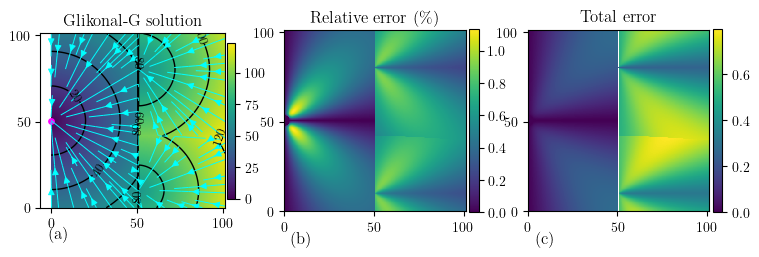

In [13]:
X,Y=np.meshgrid(np.linspace(0,h*W,W),np.linspace(0,h*H,H))

tot_error=grid-true_grid

tot_error[:int(saddle_2/h),W//2]=np.inf*np.ones(int(saddle_2/h))
tot_error[int(saddle_1/h)+1:,W//2]=np.inf*np.ones(H-int(saddle_1/h)-1)
tot_error[int(saddle_2/h)+1:int(saddle_1/h),W//2]=np.inf*np.ones(int(saddle_1/h)-int(saddle_2/h)-1)
rel_error=tot_error/(true_grid+1e-10)
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))
fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*h,init_pos[0]*h,color='magenta',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.04, pad=0.01)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,-grid_chars[:,:,1],-grid_chars[:,:,0],density=0.8,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)

plt.savefig('./pics/glikonal_mrap_test_2saddles_h025.png',dpi=600,bbox_inches='tight')

## Test with barrier without slits
 The barrier's altitude is such that one can glide directly if the starting point is obliquous with respect to the airport, however coming straight from the right, the barrier increases the minimal altitude required


In [14]:
H=101
W=101

h=1 #spacing of the square grid
elevation=np.zeros([H,W])
barrier_height=60
elevation[:,W//2]=barrier_height*np.ones(H)
g=1
#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=0

In [15]:
#use the solver to obtain the approximate solution
radius=3
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation, h,g,H,W)

grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))

In [16]:
#computing the true solution
blocked_grid=np.zeros([H,W])
true_grid=np.ones([H,W])
for y in range(H):
    for x in range(W):
        true_grid[y,x]=init_altitude+np.linalg.norm([h*(y-init_pos[0]),h*(x-init_pos[1])])/g

min_blocked_y=0
max_blocked_y=0

for y in range(H//2):
    x=W//2
    arrival_alt_at_barrier=init_altitude+np.linalg.norm([h*(y-init_pos[0]),h*(x-init_pos[1])])/g
    if(arrival_alt_at_barrier>=elevation[y,W//2]):
        min_blocked_y=y
min_blocked_y=min_blocked_y+1

for y in range(H//2,H):
    x=W//2
    arrival_alt_at_barrier=init_altitude+np.linalg.norm([h*(y-init_pos[0]),h*(x-init_pos[1])])/g
    if(arrival_alt_at_barrier<elevation[y,W//2]):
        max_blocked_y=y
print(min_blocked_y,max_blocked_y)

for y in range(0,min_blocked_y):
    for x in range(W//2,W):
        y_int=y+(x-W//2)/x*(init_pos[0]-y)
        if(y_int>=min_blocked_y):
            true_grid[y,x]=barrier_height+np.linalg.norm([h*(y-min_blocked_y),h*(x-W//2)])/g
            blocked_grid[y,x]=1
            

for y in range(min_blocked_y,max_blocked_y):
    for x in range(W//2,W):
        true_grid[y,x]=barrier_height+h*(x-W//2)
    
for y in range(max_blocked_y,H):
    for x in range(W//2,W):
        y_int=y-(x-W//2)/x*(y-init_pos[0])
        if(y_int<=max_blocked_y):
            true_grid[y,x]=barrier_height+np.linalg.norm([h*(y-max_blocked_y),h*(x-W//2)])/g
            blocked_grid[y,x]=1

17 83


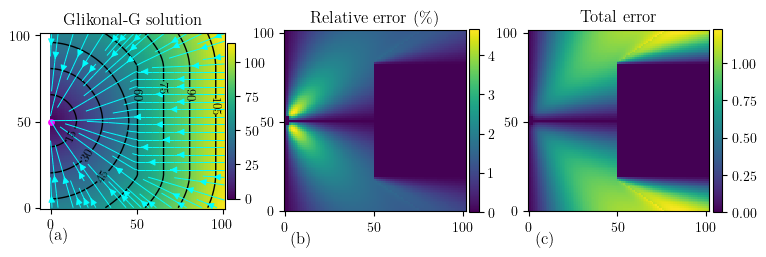

In [17]:
X,Y=np.meshgrid(np.linspace(0,h*W,W),np.linspace(0,h*H,H))

tot_error=grid-true_grid
rel_error=tot_error/(true_grid+1e-10)
fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))
fig.tight_layout(pad=0.67)

im0=axes[0].pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=axes[0].contour(X,Y,grid,colors='k',linewidths=1)
axes[0].clabel(CS, fontsize=9, inline=True)
axes[0].scatter(init_pos[1]*h,init_pos[0]*h,color='magenta',s=15)
im1=axesim1=axes[1].pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
im2=axes[2].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')
fig.colorbar(im0,ax=axes[0],fraction=0.04, pad=0.01)
fig.colorbar(im1,ax=axes[1],fraction=0.047, pad=0.02)
fig.colorbar(im2,ax=axes[2],fraction=0.047, pad=0.02)
axes[0].streamplot(X,Y,-grid_chars[:,:,1],-grid_chars[:,:,0],density=0.8,color='aqua',linewidth=0.7)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
axes[0].set_title('Glikonal-G solution')
axes[1].set_title('Relative error (\%)')
axes[2].set_title('Total error')
axes[0].set_xticks([0,50,100])
axes[1].set_xticks([0,50,100])
axes[2].set_xticks([0,50,100])
axes[0].set_yticks([0,50,100])
axes[1].set_yticks([0,50,100])
axes[2].set_yticks([0,50,100])
axes[0].text(0.1, -0.15, "(a)", ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
axes[1].text(0.1, -0.15, "(b)", ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
axes[2].text(0.1, -0.15, "(c)", ha='center', va='center', transform=axes[2].transAxes, fontsize=12)


plt.savefig('./pics/glikonal_mrap_test_barrier.pdf',dpi=600,bbox_inches='tight')

## Remarks
The tests are considered passed if the relative error is smaller than about 5% on all of them.
Notice that the solution obtained with FMM_MRAP is always greater than the true one, meaning that when an error is present, the algorithm is overestimating the altitude needed for reentry. Thus errors make the solution more conservative. 